In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_gaussiandist_datasets(sigma):
    pa_mean, pb_mean, pc_mean = np.array([-1, -1]), np.array([1, -1]), np.array([0, 1])
    pa_cov, pb_cov, pc_cov = sigma*np.array([[2, 0.5], [0.5, 1]]), sigma*np.array([[1, -0.5], [-0.5, 2]]), sigma*np.array([[1, 0], [0, 2]])
    pa_samples = np.random.multivariate_normal(pa_mean, pa_cov, size=100)
    pb_samples = np.random.multivariate_normal(pb_mean, pb_cov, size=100)
    pc_samples = np.random.multivariate_normal(pc_mean, pc_cov, size=100)
    
    ent_dataset = np.concatenate((pa_samples, pb_samples, pc_samples))
    return ent_dataset

In [3]:
def run_kmeans(dataset, k):
    x_min_bound, y_min_bound = np.min(dataset, axis=0)
    x_max_bound, y_max_bound = np.max(dataset, axis=0)
    centers = []
    for i in range(k):
        rand_x = np.random.uniform(x_min_bound, x_max_bound)
        rand_y = np.random.uniform(y_min_bound, y_max_bound)
        centers.append([rand_x, rand_y])
    centers = np.array(centers)
    converged = False
    while not converged:
        dist_from_centers = np.linalg.norm(dataset[:, np.newaxis]-centers, axis=2)
        pred_labels = np.argmin(dist_from_centers, axis=1)
        
        new_centers = np.array([dataset[pred_labels==i].mean(axis=0) for i in range(k)])
        if np.all(centers==new_centers):
            converged=True
        centers = new_centers
    return centers, pred_labels

def compute_objective_function(centers, dataset, pred_labels, k):
    net_obj = []
    for i in range(k):
        net_obj.extend([np.linalg.norm(dataset[pred_labels==i]-centers[i])**2])
    return np.sum(net_obj)

def compute_accuracy(dataset, centers, pred_labels):
    dataset_means = np.array([np.mean(dataset[i*100:(i+1)*100], axis=0) for i in range(3)])
    all_dist = np.linalg.norm(dataset_means[:, np.newaxis]-centers, axis=2)
    labels_ = np.argmin(all_dist, axis=1)
    labels = []
    for i in range(3):
        labels.extend([labels_[i]]*100)
    return np.sum([1 if labels[i]==pred_labels[i] else 0 for i in range(len(labels))])/len(labels)

In [4]:
def run_estep_part(dataset, mean_, cov_):
    inv_cov = np.linalg.inv(cov_)
    det_cov = np.linalg.det(cov_)
    exp_ = np.exp(-0.5*np.sum((dataset-mean_).dot(inv_cov)*(dataset-mean_), axis=1))
    return 1.0/np.sqrt((2*np.pi)**dataset.shape[1]*det_cov)*exp_

def run_gmm(dataset, k, tol_level):
    mean_ = dataset[np.random.choice(dataset.shape[0], k, replace=False)]
    cov_ = np.array([np.cov(dataset.T) for i in range(k)])
    p_z = np.array([1/k for i in range(k)])
    weights = np.zeros((dataset.shape[0], k))
    
    converged = False
    prev_likelihood = None
    while not converged:
        for i in range(k):
            weights[:, i] = p_z[i]*run_estep_part(dataset, mean_[i], cov_[i])
            
        weights = weights/weights.sum(axis=1, keepdims=True)
        
        for i in range(k):
            w_sum_k = np.sum(weights[:, i])
            p_z[i] = w_sum_k/dataset.shape[0]
            mean_[i] = np.sum(dataset*weights[:, i].reshape(-1, 1), axis=0)/w_sum_k
            cov_[i] = np.dot((dataset-mean_[i]).T, (dataset-mean_[i])*weights[:, i].reshape(-1, 1))/w_sum_k
            
        likelihood = 0
        for i in range(k):
            likelihood += p_z[i]*run_estep_part(dataset, mean_[i], cov_[i])
        likelihood = np.sum(np.log(likelihood))
        
        if prev_likelihood is not None and abs(likelihood-prev_likelihood)<tol_level:
            converged = True
            
        prev_likelihood = likelihood
    return mean_, cov_, p_z, weights

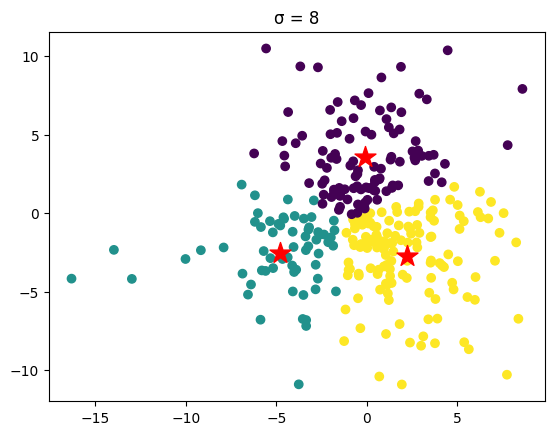

In [7]:
sigmas = [0.5, 1, 2, 4, 8]
km_accuracies = []
km_objective = []
for sigma in sigmas:
    dataset = generate_gaussiandist_datasets(sigma)
    centers, pred_labels = run_kmeans(dataset, k=3)
    
    km_accuracies.append(compute_accuracy(dataset, centers, pred_labels))
    km_objective.append(compute_objective_function(centers, dataset, pred_labels, k=3))
    
    plt.clf()
    plt.scatter(dataset[:, 0], dataset[:, 1], c=pred_labels)
    plt.scatter(centers[:, 0], centers[:, 1], marker='*', s=250, c='red')
    plt.title(f"σ = {sigma}")
    #plt.show()
    plt.savefig(f'km_sigma{sigma}.png')

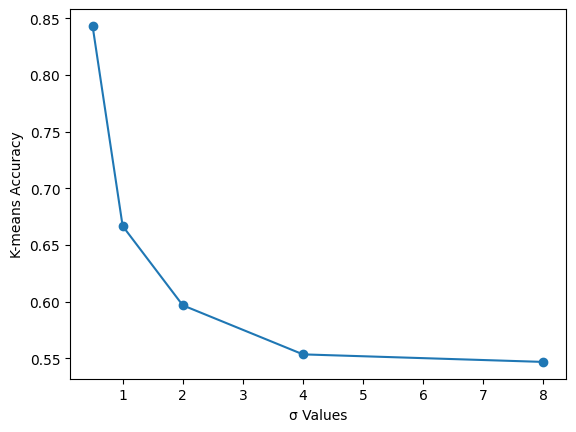

In [12]:
plt.plot(sigmas, km_accuracies, marker='o')
plt.xlabel("σ Values")
plt.ylabel("K-means Accuracy")
plt.savefig('km_accuracy.png')

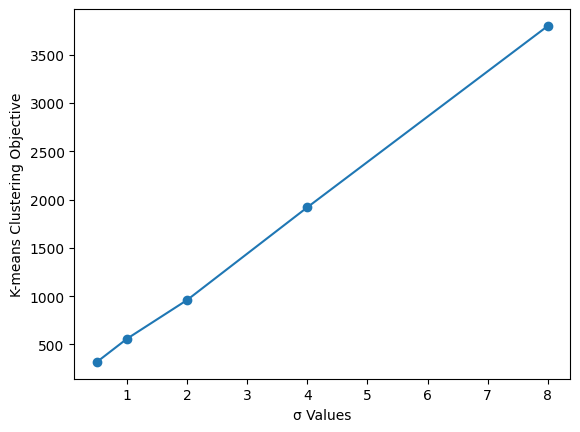

In [13]:
plt.plot(sigmas, km_objective, marker='o')
plt.xlabel("σ Values")
plt.ylabel("K-means Clustering Objective")
plt.savefig('km_objective.png')

In [37]:
from tabulate import tabulate
data = list(zip(sigmas, km_accuracies, km_objective))

headers = ["σ Values", "K-means Accuracy", "K-means Clustering Objective"]

table = tabulate(data, headers=headers, tablefmt="fancy_grid")
print(table)

╒════════════╤════════════════════╤════════════════════════════════╕
│   σ Values │   K-means Accuracy │   K-means Clustering Objective │
╞════════════╪════════════════════╪════════════════════════════════╡
│        0.5 │           0.843333 │                        319.188 │
├────────────┼────────────────────┼────────────────────────────────┤
│        1   │           0.666667 │                        559.261 │
├────────────┼────────────────────┼────────────────────────────────┤
│        2   │           0.596667 │                        960.204 │
├────────────┼────────────────────┼────────────────────────────────┤
│        4   │           0.553333 │                       1920.16  │
├────────────┼────────────────────┼────────────────────────────────┤
│        8   │           0.546667 │                       3797.67  │
╘════════════╧════════════════════╧════════════════════════════════╛


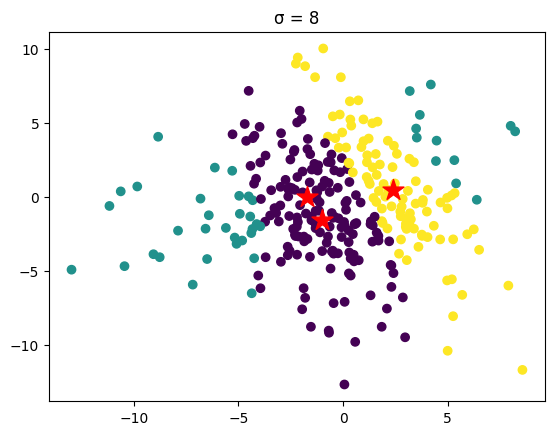

In [33]:
gmm_accuracies = []
gmm_objective = []
for sigma in sigmas:
    dataset = generate_gaussiandist_datasets(sigma)
    mean, cov, p_z, weights = run_gmm(dataset, k=3, tol_level=1e-5)
    pred_labels = np.argmax(weights, axis=1)
    likelihood = 0
    for i in range(3):
        likelihood += p_z[i]*run_estep_part(dataset, mean[i], cov[i])
    likelihood = np.sum(np.log(likelihood))
    gmm_objective.append(-likelihood)
    gmm_accuracies.append(compute_accuracy(dataset, mean, pred_labels))
    
    plt.clf()
    plt.scatter(dataset[:, 0], dataset[:, 1], c=pred_labels)
    plt.scatter(mean[:, 0], mean[:, 1], marker='*', s=250, c='red')
    plt.title(f"σ = {sigma}")
    #plt.show()
    plt.savefig(f'gmm_sigma{sigma}.png')

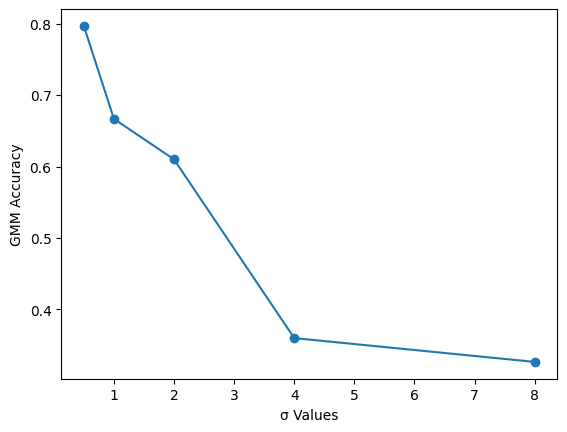

In [35]:
plt.plot(sigmas, gmm_accuracies, marker='o')
plt.xlabel("σ Values")
plt.ylabel("GMM Accuracy")
plt.savefig('gmm_accuracy.png')

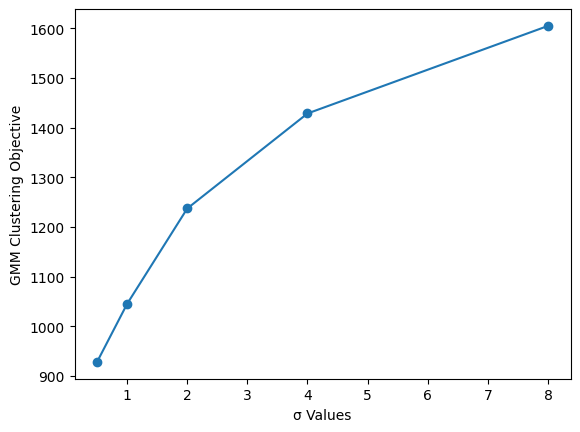

In [36]:
plt.plot(sigmas, gmm_objective, marker='o')
plt.xlabel("σ Values")
plt.ylabel("GMM Clustering Objective")
plt.savefig('gmm_objective.png')

In [38]:
from tabulate import tabulate
data = list(zip(sigmas, gmm_accuracies, gmm_objective))

headers = ["σ Values", "GMM Accuracy", "GMM Clustering Objective"]

table = tabulate(data, headers=headers, tablefmt="fancy_grid")
print(table)

╒════════════╤════════════════╤════════════════════════════╕
│   σ Values │   GMM Accuracy │   GMM Clustering Objective │
╞════════════╪════════════════╪════════════════════════════╡
│        0.5 │       0.796667 │                    928.082 │
├────────────┼────────────────┼────────────────────────────┤
│        1   │       0.666667 │                   1044.99  │
├────────────┼────────────────┼────────────────────────────┤
│        2   │       0.61     │                   1236.98  │
├────────────┼────────────────┼────────────────────────────┤
│        4   │       0.36     │                   1428.29  │
├────────────┼────────────────┼────────────────────────────┤
│        8   │       0.326667 │                   1604.58  │
╘════════════╧════════════════╧════════════════════════════╛
